<a href="https://colab.research.google.com/github/alex-jk/SWB-GVCEH/blob/main/models/relevance_model/Reddit_Relevancy_Models_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Install and import necessary libraries

In [1]:
!pip install setfit
!pip install tqdm
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 670.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import gdown
import json
import pandas as pd

Mounted at /content/drive


In [3]:
from setfit import SetFitModel
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")

from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import concurrent.futures

import numpy as np
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

model_sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

##### Import the full Reddit dataset
- remove duplicates to make sure that posts are unqiue
- TitleText is the text column of interest

In [4]:
# https://drive.google.com/file/d/15reL84i-9niSW4Oa0_1oxR82-5UpAybo/view?usp=sharing


# url = 'https://drive.google.com/uc?id=15reL84i-9niSW4Oa0_1oxR82-5UpAybo'
# output_reddit_data = 'Complete_Data_v3.json'
# gdown.download(url, output_reddit_data, quiet=False)

file_path = '/content/drive/My Drive/SWB-GVCEH/Complete_Data_v3.json'
reddit_data_df = pd.read_json(file_path)

# with open(output_reddit_data, 'r') as f:
#     reddit_data = json.load(f)

# reddit_data_df = pd.DataFrame(reddit_data)
print(f"\ncd_test shape: {reddit_data_df.shape}")
print(f"\n--------------- Columns: {reddit_data_df.columns}")

select_cols = ['Subreddit', 'Title', 'Text', 'TitleText']
reddit_data_df = reddit_data_df[select_cols]
reddit_data_df.drop_duplicates(inplace=True)
reddit_data_df.reset_index(drop=True, inplace=True)

print("\n------------------------------")
print(reddit_data_df.head())


cd_test shape: (11160, 23)

--------------- Columns: Index(['index', 'Subreddit', 'Title', 'Text', 'TitleText', 'relevance_score',
       'most_common_centroid_id', 'top_terms_from_centroid',
       'topics_from_centroid', 'Score_model2', 'label_model2', 'label_model1',
       'relevant_sentences', 'topic_num', 'Relevant_document',
       'Relevant_topic', 'topic_label', 'Sentiment_Full',
       'Sentence_Level_Sentiment_Compund',
       'Relevent_Sentence_Sentiment_Compund', 'BERT_sentiment_all',
       'BERT_sentiments_relevant_sentences', 'manual_label'],
      dtype='object')

------------------------------
    Subreddit                                              Title  \
0  VictoriaBC  True change around homelessness from the homel...   
1  VictoriaBC  New transitional housing facility on Douglas o...   
2  VictoriaBC   Where to buy a reasonably priced Christmas tree?   
3  VictoriaBC  Looking for a Christmas tree? Please consider ...   
4  VictoriaBC                           

##### Clone github repo to download twitter data
- Twitter data will be used for the cosine similarity model

In [5]:
%cd ..
!rm -rf SWB-GVCEH

/


In [6]:
%cd /content
!apt-get install git
!git config --global user.name "alex-jk"
!git config --global user.email "alex.joukova@gmail.com"
!git clone https://github.com/alex-jk/SWB-GVCEH.git
%cd SWB-GVCEH

import os
os.environ['GITHUB_PAT'] = 'ghp_xxx'
# Set your git remote URL to include the PAT for authentication
repo_url = 'https://github.com/alex-jk/SWB-GVCEH.git'  # Replace with your repository's URL
pat = os.environ['GITHUB_PAT']
repo_url_with_token = repo_url[:8] + pat + "@" + repo_url[8:]

!git remote set-url origin {repo_url_with_token}
# Check the current remote URL
!git remote -v

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Cloning into 'SWB-GVCEH'...
remote: Enumerating objects: 5477, done.
remote: Counting objects: 100% (1173/1173), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 5477 (delta 829), reused 1052 (delta 751), pack-reused 4304
Receiving objects: 100% (5477/5477), 114.39 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (3741/3741), done.
Updating files: 100% (153/153), done.
/content/SWB-GVCEH
origin	https://ghp_xxx@github.com/alex-jk/SWB-GVCEH.git (fetch)
origin	https://ghp_xxx@github.com/alex-jk/SWB-GVCEH.git (push)


In [7]:
# List of file names
file_names = [
    'GVCEH-tweets-combined_2023-02-08.csv',
    'GVCEH-tweets-combined_2023-01-30.csv',
    'GVCEH-tweets-combined_2023-01-21.csv',
    'GVCEH-tweets-combined_2023-01-12.csv'
]

# Base URL for raw files in the GitHub repository
base_url = 'https://raw.githubusercontent.com/alex-jk/SWB-GVCEH/main/data/processed/twitter/github_actions/'

# Initialize a list to collect the DataFrames
dfs = []

for file_name in file_names:
    # Construct the full URL for the current file
    file_url = base_url + file_name
    # Read the CSV file
    current_df = pd.read_csv(file_url)
    # Append the DataFrame to the list
    dfs.append(current_df)

# Concatenate all DataFrames in the list
tweets_combined_df = pd.concat(dfs, ignore_index=True)
# Remove duplicates
tweets_combined_df = tweets_combined_df.drop_duplicates().reset_index(drop=True)

# Displaying the first few rows of the DataFrame
print(tweets_combined_df.shape)
print(tweets_combined_df.columns)
print(tweets_combined_df.head())

(5435, 17)
Index(['Unnamed: 0', 'text', 'scrape_time', 'tweet_id', 'created_at',
       'reply_count', 'quote_count', 'like_count', 'retweet_count',
       'geo_full_name', 'geo_id', 'username', 'num_followers',
       'search_keywords', 'search_neighbourhood', 'sentiment', 'score'],
      dtype='object')
   Unnamed: 0                                               text  \
0           0  RT pressjournal: Colonsay islanders and people...   
1           1  Colonsay islanders and people who have left th...   
2           7  @ArianeBurgessHI Serviced plots for 25k are ex...   
3           9  RT @VicBuilders: "25-unit townhome development...   
4          27  @OurNewHomecoach @laughatthemoon2 There is so ...   

                  scrape_time             tweet_id                 created_at  \
0  2023-02-07 03:20:43.040309  1622564995115503616  2023-02-06 11:56:55+00:00   
1  2023-02-07 03:20:43.040317  1622550741599625221  2023-02-06 11:00:16+00:00   
2  2023-02-07 03:20:51.207543  1622549961

##### Load pre-trained twitter relevancy model
Check that tweets are considered relevant by the model
- all tweets were found to be relevant by the model

In [8]:
# Load the pretrained SetFit model
model = SetFitModel.from_pretrained("sheilaflood/gvceh-setfit-rel-model2")

# Define a function to make predictions
def get_prediction(text):
    prediction = model([text])[0]
    return prediction

config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/7.48k [00:00<?, ?B/s]

In [ ]:
# Apply the model to each row in the 'text' column with a progress bar
tqdm.pandas()  # Enable tqdm for pandas
tweets_combined_df['relevant'] = tweets_combined_df['text'].progress_apply(get_prediction)

In [ ]:
def extract_integer_from_tensor(tensor_val):
    return tensor_val.item()

# Apply this function to the entire column
tweets_combined_df['relevant'] = tweets_combined_df['relevant'].apply(extract_integer_from_tensor)

# Print value counts for the 'relevant' column
print(tweets_combined_df['relevant'].value_counts())

#### Reddit Data Labelling - Model #1
Perform K-Means clustering of twitter data

Generate embeddings of twitter posts

In [10]:
twitter_embeddings = model_sent_transformer.encode(tweets_combined_df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

#### Run K-Means on twitter embeddings

Current k: 1
Current k: 2
Current k: 3
Current k: 4
Current k: 5
Current k: 6
Current k: 7
Current k: 8
Current k: 9
Current k: 10
Current k: 11
Current k: 12
Current k: 13
Current k: 14
Current k: 15
Current k: 16
Current k: 17
Current k: 18
Current k: 19
Current k: 20
Current k: 21
Current k: 22
Current k: 23
Current k: 24
Current k: 25
Current k: 26
Current k: 27
Current k: 28
Current k: 29
Current k: 30
Current k: 31
Current k: 32
Current k: 33
Current k: 34
Current k: 35
Current k: 36
Current k: 37
Current k: 38
Current k: 39


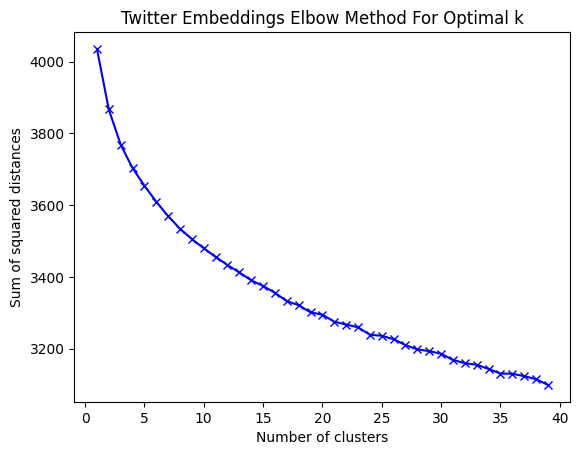

In [11]:
# Calculate sum of squared distances for different number of clusters
Sum_of_squared_distances = []
K = range(1,40)  # Adjust the range based on your dataset
for k in K:
    print(f"Current k: {k}")
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(twitter_embeddings)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Twitter Embeddings Elbow Method For Optimal k')
plt.show()

##### Assign clusters to embeddings

In [13]:
k = 15  # number of clusters
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(twitter_embeddings)

cluster_centroids = kmeans.cluster_centers_

tweets_combined_df['cluster'] = kmeans.labels_

##### Functions to process reddit posts

In [14]:
# Function to split text into sentences
def spacy_sentence_split(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

# Function to process a single Reddit post and determine its relevance
def process_post_for_relevance(post, model, centroids, threshold):
    sentences = spacy_sentence_split(post)
    sentence_embeddings = model.encode(sentences, show_progress_bar=False)
    sentence_relevance_scores = cosine_similarity(sentence_embeddings, centroids)
    max_scores = sentence_relevance_scores.max(axis=1)
    max_score_indices = sentence_relevance_scores.argmax(axis=1)
    # print(len(sentence_embeddings))
    # print(max_scores)
    # print(max_score_indices)

    relevant_sentences = max_scores > threshold
    relevant_centroid_ids = max_score_indices[relevant_sentences]
    # print(relevant_centroid_ids)
    relevance_score = relevant_sentences.mean()  # Proportion of sentences above the threshold

    centroid_counter = Counter(relevant_centroid_ids)
    # print(centroid_counter)
    if len(centroid_counter) == 0:
        most_common_centroid_ids = None  # No relevant sentences
    else:
        # Find the maximum count for the centroids
        max_count = centroid_counter.most_common(1)[0][1]
        # Get all centroid IDs that have the maximum count (ties included)
        most_common_centroid_ids = [centroid_id for centroid_id, count in centroid_counter.items() if count == max_count]

    return relevance_score, most_common_centroid_ids

In [15]:
# Parallel processing function
def parallel_relevance_computation(reddit_posts, model, centroids, threshold, max_workers=10):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda post: process_post_for_relevance(post, model, centroids, threshold), reddit_posts), total=len(reddit_posts)))

    # Unpack the results into two separate lists
    relevance_scores, most_common_centroid_ids = zip(*results)
    return relevance_scores, most_common_centroid_ids

In [16]:
# Apply parallel relevance computation to the DataFrame
relevance_scores, most_common_centroid_ids = parallel_relevance_computation(reddit_data_df['TitleText'].tolist(), model_sent_transformer, cluster_centroids, threshold=0.5)

# Assign the results to separate columns in the DataFrame
reddit_data_df['relevance_score'] = relevance_scores
reddit_data_df['most_common_centroid_id'] = most_common_centroid_ids

  0%|          | 0/11151 [00:00<?, ?it/s]

##### Assign Model #1 labels

In [20]:
# Filter relevant posts based on a relevance score threshold
reddit_data_df['label_model1'] = np.where(reddit_data_df['relevance_score'] >= 0.1, 1, 0)

relevant_reddit_posts = reddit_data_df[reddit_data_df['relevance_score'] > 0.1].reset_index(drop=True)
print(f"\nOriginal number of posts: {len(reddit_data_df.index)}")
print(f"\nNumber of relevant posts: {len(relevant_reddit_posts.index)}")


Original number of posts: 11151

Number of relevant posts: 3311


#### Twitter Relevancy Model on Reddit sentences - Model #2 (INITIAL VERSION)

In [21]:
# Function to chunk a long text into smaller parts
def tokenize_into_sentences(text):
    return sent_tokenize(text)


def predict_relevance(text):
    sentences = tokenize_into_sentences(text)
    if not sentences:  # If no sentences, return default values
        return 0.0, 0

    # Assuming model(sentences) returns a tensor of predictions; convert this to a list
    predictions_tensor = model(sentences)
    predictions = predictions_tensor.tolist()  # Convert tensor to list

    # Calculate the score as a percentage of relevant sentences
    score = sum(predictions) / len(sentences) * 100
    score = round(score, 2)  # Round to 2 decimal places for readability

    # Determine binary output: 1 if 10% or more sentences are relevant, else 0
    binary_output = 1 if score >= 10 else 0

    return score, binary_output

In [ ]:
tqdm.pandas(desc="Processing Posts")

reddit_data_df[['Score_model2', 'label_model2']] = reddit_data_df['TitleText'].progress_apply(
    lambda x: pd.Series(predict_relevance(x))
)

Processing Posts:   0%|          | 0/11151 [00:00<?, ?it/s]

#### Extract relevant sentences step - for sentiment analysis

In [17]:
def extract_relevant_sentences(text):
    sentences = tokenize_into_sentences(text)
    if not sentences:  # If no sentences, return an empty string
        return ""

    predictions = model(sentences)

    # Extract sentences that are marked relevant by the model
    relevant_sentences = [sentence for sentence, prediction in zip(sentences, predictions) if prediction == 1]
    concatenated_sentences = " ".join(relevant_sentences)

    return concatenated_sentences

In [18]:
tqdm.pandas(desc="Extracting relevant sentences")

reddit_data_df['relevant_sentences'] = reddit_data_df['TitleText'].progress_apply(extract_relevant_sentences)

Extracting relevant sentences:   0%|          | 0/11151 [00:00<?, ?it/s]

NameError: name 'tokenize_into_sentences' is not defined

#### SetFit Relevancy Model - Model #2 UPDATED

##### Import train and test data
Import labelled json data

In [ ]:
file_path_sample = '/content/drive/My Drive/SWB-GVCEH/reddit_manual_labels_sample01.json'
reddit_manual_labels_sample01 = pd.read_json(file_path_sample, lines=True)

print(f"\n---- df reddit_manual_labels_sample01 shape: {reddit_manual_labels_sample01.shape}")
print(f"\n Columns: {reddit_manual_labels_sample01.columns}")

print(f"\n-----------------------")
print(reddit_manual_labels_sample01.head())

In [ ]:
file_path_sample02 = '/content/drive/My Drive/SWB-GVCEH/reddit_manual_labels_sample02.json'

reddit_manual_labels_sample02 = pd.read_json(file_path_sample02, lines=True)
print(f"\n---- df reddit_manual_labels_sample02 shape: {reddit_manual_labels_sample02.shape}")
print(f"\n Columns: {reddit_manual_labels_sample02.columns}")

print(f"\n-----------------------")
print(reddit_manual_labels_sample02.head())

##### Split into test and train

In [ ]:
# Shuffle the DataFrame
df_shuffled = reddit_manual_labels_sample02.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled['TitleText'].fillna('', inplace=True)

split_size = int(len(df_shuffled) * 0.65)

select_cols = ['TitleText', 'manual_label']
# Split the DataFrame into two parts
sample_train = df_shuffled[:split_size][select_cols].copy().reset_index(drop=True)
sample_test = df_shuffled[split_size:][select_cols].reset_index(drop=True)
print(f"\nTrain dataset length: {len(sample_train)}, test dataset length: {len(sample_test)}")

value_counts_train = sample_train['manual_label'].value_counts()
print("\n----------------")
print(value_counts_train)

value_counts_test = sample_test['manual_label'].value_counts()
print("\n----------------")
print(value_counts_test)

In [ ]:
train_dataset = Dataset.from_pandas(sample_train)
test_dataset = Dataset.from_pandas(sample_test)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})